# Avec Q_learning

In [1]:
import numpy as np
import logging
logging.getLogger('tensorflow').disabled = True
import tensorflow as tf
import keras
import cv2
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque

In [6]:
class DQN:

    def __init__(self,model_name):
        try:
            self.model = keras.models.load_model(model_name)
        except:
            self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(32, activation="elu", input_shape=[4]),
            tf.keras.layers.Dense(32, activation="elu"),
            tf.keras.layers.Dense(2)
        ])
            self.model.save(model_name)
        self.env = gym.make("CartPole-v1",render_mode="rgb_array")
        self.replay_buffer = deque(maxlen=2000)
        self.batch_size = 32
        self.discount_factor = 0.95
        self.optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-2)
        self.loss_fn = tf.keras.losses.mean_squared_error
        self.model_name = model_name


    def epsilon_greedy(self, state):
        if np.random.rand()<self.epsilon:
            return np.random.randint(2)
        else:
            Q_values = self.model.predict(state[np.newaxis],verbose=0)[0] 
            #np.newaxis augment la dimension de state
            #verbose = 0 => don't show the progress bar of evaluating
            return Q_values.argmax()
        
    def play_one_step(self, state ):
        action = self.epsilon_greedy(state)
        next_state, reward, done, truncated, info = self.env.step(action)
        self.replay_buffer.append((state, action, reward, next_state, done, truncated))
        return next_state, reward, done, truncated, info
    
    
    def sample_experiences(self):
        indexes = np.random.randint(len(self.replay_buffer),size=self.batch_size)
        batch = [self.replay_buffer[index] for index in indexes]
        return [
                np.array([experience[field_index] for experience in batch])
                for field_index in range(6)
            ]    
    def training_step(self):
        experiences = self.sample_experiences()
        states, actions, rewards, next_states, dones, truncateds = experiences
        next_Q_values = self.model.predict(next_states, verbose=0)
        max_next_Q_values = next_Q_values.max(axis=1)
        runs = 1.0 - (dones | truncateds)  # episode is not done or truncated
        target_Q_values = rewards + runs * self.discount_factor * max_next_Q_values
        target_Q_values = target_Q_values.reshape(-1, 1)
        mask = tf.one_hot(actions, 2)
        with tf.GradientTape() as tape:
            all_Q_values = self.model(states)
            Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(self.loss_fn(target_Q_values, Q_values))
            print(loss)
        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.model.save(self.model_name,overwrite=True)

    def train_n_games(self,n):
        game_rewards = []
        for episode in range(n):
            obs, info = self.env.reset()    
            for step in range(500):
                self.epsilon = max(0.7-episode/0.7/300,0.01)
                obs, reward, done, truncated, info = self.play_one_step(obs)
                final_step=step
                if done or truncated:
                    break
            print(f"\rEpisode: {episode + 1}, Steps: {step + 1}, eps: {self.epsilon:.3f}",end="")
            game_rewards.append(final_step)
            if episode > 3 :
                self.training_step()
        
        return game_rewards
    
    def make_video(self,video_name):
        video = cv2.VideoWriter(video_name+str(".avi"),cv2.VideoWriter_fourcc(*'MJPG'),10,(600,400))
        self.epsilon = 0
        obs, info = self.env.reset()
        for step in range(500):
            obs, reward, done, truncated, info = self.play_one_step(obs)
            img = self.env.render()
            img = cv2.resize(img,(600,400))
            video.write(img)
            if done or truncated:
                break
        video.release()
        cv2.destroyAllWindows() 
        




Episode: 5, Steps: 77, eps: 0.681tf.Tensor(3.12087, shape=(), dtype=float32)


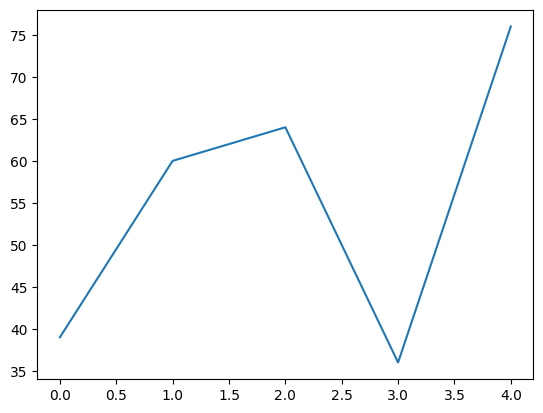

In [7]:
dqn = DQN("my_dqn_model4")
n = 5
game_rewards = dqn.train_n_games(n)
plt.plot(range(len(game_rewards)),game_rewards)
plt.show()


In [55]:
dqn.make_video("my_video3")
